# Laboratorio 8 (Segmentación de Clientes de Banco) - Inteligencia Artificial
Autores: Stefano Aragoni, Carol Arévalo, Luis Santos

_________

En este caso, se tiene un dataset en el cual se desea analizar la segmentación de clientes de un banco. Es dataset provisto contiene información de diferentes trasacciones realizadas por clientes. Del cliente, tenemos información como su fecha de nacimiento, género, ubicación, dinero actual en su cuenta, así como la cantidad de dinero involucrada en la respectiva transacción.

A continuación se presenta cómo se utilizó Mixed Model para poder hacer la agrupación de clientes según diferentes características provistas por el dataset.

_____________

### Task 1.0: Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [30]:
# Importar librerías 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets

# Cargar el dataset
data = pd.read_csv('bank_transactions.csv')

data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


##### Datos Faltantes
En este caso, se encontró que CustomerDOB contaba con datos faltantes. Por tal razón, posteriormente se utilizó un método para poder rellenar dichos datos faltantes.

Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'], dtype='object')

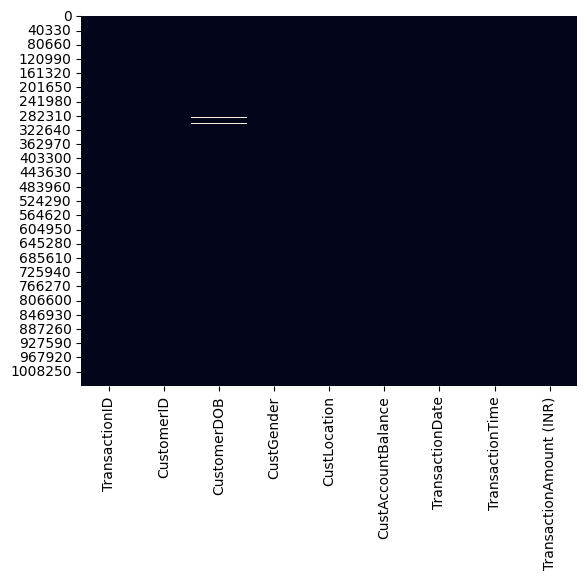

In [31]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

En caso hayan datos faltantes que no se pueden observar en la gráfica, a continuación se realizó un proceso que rellena datos faltantes con promedio de datos.

In [32]:
for col in data.columns[data.isnull().any()]:

    if data[col].dtype == 'float64' or data[col].dtype == 'int64':
        data[col].fillna(data[col].mean(), inplace=True)

    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

data.columns[data.isnull().any()]

Index([], dtype='object')

In [33]:
data_copy = data.copy()

In [34]:
data = data_copy.copy()

##### Encoding
Convertir variables que no son numéricas a numéricas. En este caso, principalmente se estaba conviertiendo fecha de nacimiento a edad. Se mapeó género a 0 o 1, correspondiente a M y F. Por otro lado, se eliminaron variables de ID, ya que no presentan información útil para la clasificación de clientes; solo son identificadores únicos.

In [35]:
import datetime
from datetime import timedelta, date
from sklearn.preprocessing import LabelEncoder

#-------------------EDAD-------------------------
# Convertir CustomerDOB a año de nacimiento
data['YOB'] = '19' + data['CustomerDOB'].str[-2:]
data['YOB'] = data['YOB'].astype(int)

# Eliminar columna de DOB
data = data.drop(['CustomerDOB'], axis=1)

# Determinar edad
data['Age'] = 2023 - data['YOB']

# Eliminar columna de YOB
data = data.drop(['YOB'], axis=1)

#-------------------GENERO-------------------------
# Convertir genero a int. M = 0, F = 1
data['CustGender'] = data['CustGender'].map({'M': 0, 'F': 1})

#------------ELIMINAR TRANSACTIONS----------------
data = data.drop(['TransactionID'], axis=1)

#----------ELIMINAR VARIABLES QUE NO DAN INFO DE CLIENTE --------------
data = data.drop(['TransactionDate'], axis=1)

#-----------------ELIMINAR CID--------------------
# promediar CustAccountBalance y TransactionAmount de los mismos clientes y dejar una columna por cliente
data = data.groupby(['CustomerID']).mean()

data.head()

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_60125/1668597232.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['CustomerID']).mean()


,CustGender,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age
CustomerID,,,,,
C1010011,0.5,76340.635,67521.0,2553.0,35.5
C1010012,0.0,24204.490,204409.0,1499.0,29.0
C1010014,0.5,100112.950,187378.0,727.5,35.0
C1010018,1.0,496.180,170254.0,30.0,33.0
C1010024,0.0,87058.650,141103.0,5000.0,58.0


In [39]:
# Pasar data a formato de matriz sin CustomerID
custGender = data['CustGender'].values
custAge = data['Age'].values
custAccountBalance = data['CustAccountBalance'].values
transactionAmount = data['TransactionAmount (INR)'].values
transactionType = data['TransactionTime'].values

# combinar en dataset de pandas
data = pd.DataFrame({'CustGender': custGender, 'Age': custAge, 'CustAccountBalance': custAccountBalance, 'TransactionAmount (INR)': transactionAmount, 'TransactionTime': transactionType})

# eliminar donde CustGender no es igual a 0 o 1
data = data[(data['CustGender'] == 0) | (data['CustGender'] == 1)]

print(data.head())

   CustGender   Age  CustAccountBalance  TransactionAmount (INR)  \
1         0.0  29.0           24204.490                   1499.0   
3         1.0  33.0             496.180                     30.0   
4         0.0  58.0           87058.650                   5000.0   
5         1.0  35.0          296828.370                    557.0   
6         0.0  37.0            5200.155                    932.0   

   TransactionTime  
1         204409.0  
3         170254.0  
4         141103.0  
5          95212.0  
6         162771.5  


##### Balanceo
En este caso se determinó que no es necesario balancear los datos debido a que es un modelo no supervisado, por lo cual no se requiere. 

##### Escalar
En este caso, se utilizó la librería de SKLearn para poder escalar y normalizar los datos que lo necesitaran. Asimismo, también se hizo un análisis pre y post escalamiento para determinar la distribución de los datos. En el preprocesamiento, se podía observar cómo ciertas variables tenían una alta desviación estándar a comparación de su respectiva media. Esto fue solucionado a través de la función de MinMaxScaler(). 

> Asimismo, es importante mencionar que la normalización de datos es importante para, según Microsoft, "tener datos que usan una escala común, sin distorsionar las diferencias en los intervalos de valores ni perder información". https://learn.microsoft.com/es-es/azure/machine-learning/component-reference/normalize-data

In [40]:
data2 = data.copy()

In [41]:
# Calcular media y desviación estándar de cada columna
print('\n\nMedia y desviación estándar de cada columna:')
data2.describe()



Media y desviación estándar de cada columna:


,CustGender,Age,CustAccountBalance,TransactionAmount (INR),TransactionTime
count,824283.000000,824283.000000,8.242830e+05,8.242830e+05,824283.000000
mean,0.253167,43.107096,1.152263e+05,1.573144e+03,157055.751088
std,0.434826,21.180864,8.151974e+05,6.591278e+03,49957.649919
min,0.000000,24.000000,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,33.000000,5.243320e+03,1.800000e+02,124803.000000
50%,0.000000,36.500000,1.793333e+04,4.877150e+02,163732.000000
75%,1.000000,43.000000,6.048961e+04,1.217390e+03,195244.000000
max,1.000000,123.000000,1.150355e+08,1.560035e+06,235959.000000


In [140]:
from sklearn.preprocessing import StandardScaler, normalize

data3 = data2.drop(['CustGender'], axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data3)
normalized_df = normalize(scaled_features) 

df_feat = pd.DataFrame(normalized_df, columns=data3.columns)
df_feat['CustGender'] = data2['CustGender'].values
print(df_feat.head())

        Age  CustAccountBalance  TransactionAmount (INR)  TransactionTime  \
0 -0.572244           -0.095933                -0.009665         0.814395   
1 -0.782246           -0.230715                -0.383793         0.433087   
2  0.754764           -0.037091                 0.558087        -0.342775   
3 -0.289142            0.168286                -0.116460        -0.935154   
4 -0.819125           -0.383435                -0.276341         0.325035   

   CustGender  
0         0.0  
1         1.0  
2         0.0  
3         1.0  
4         0.0  


##### Selección de Variables

Finalmente, se quiso determinar los 2 features que se estarían utilizando para la realización del modelo de agrupación. En este caso, se utilizó PCA para poder determinar qué 2 variables son las más significativas para los modelos a realizar. 

En este caso, se seleccionó transaction time junto con age.

In [141]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(df_feat) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

# determinar cuales variables fueron seleccionadas por PCA
selected_variables = []
for component in pca.components_:
    max_index = np.argmax(np.abs(component))
    selected_variables.append(df_feat.columns[max_index])
    
print(selected_variables)

['TransactionTime', 'Age']


_______________
### Task 1.1: Implementacion de Mixture Models

In [161]:
import numpy as np
from scipy.stats import norm
import numpy as np
from scipy.stats import multivariate_normal

def gaussian_mixture_model(X, n_components, n_iterations=100, tolerance=1e-6):
    n_samples, n_features = X.shape

    # Initialize means, covariances, and weights
    means = np.random.randn(n_components, n_features)
    covariances = [np.eye(n_features) for _ in range(n_components)]
    weights = np.ones(n_components) / n_components

    for i in range(n_iterations):
        
        # E-step
        likelihoods = np.zeros((n_samples, n_components))
        for j in range(n_components):
            likelihoods[:, j] = weights[j] * multivariate_normal.pdf(X, means[j], covariances[j])
        responsibilities = likelihoods / np.sum(likelihoods, axis=1, keepdims=True)

        # M-step
        total_responsibilities = np.sum(responsibilities, axis=0)
        weights = total_responsibilities / n_samples
        means = np.dot(responsibilities.T, X) / total_responsibilities[:, np.newaxis]
        for j in range(n_components):
            diff = X - means[j]
            covariances[j] = np.dot(responsibilities[:, j] * diff.T, diff) / total_responsibilities[j]

        # Check convergence
        log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
        if i > 0 and np.abs(log_likelihood - prev_log_likelihood) < tolerance:
            break
        prev_log_likelihood = log_likelihood

    # Calculate responsibilities
    likelihoods = np.zeros((n_samples, n_components))
    for j in range(n_components):
        likelihoods[:, j] = weights[j] * multivariate_normal.pdf(X, means[j], covariances[j])
    responsibilities = likelihoods / np.sum(likelihoods, axis=1, keepdims=True)

    # Assign data points to clusters
    clusters = np.argmax(responsibilities, axis=1)


    return means, covariances, weights, clusters


means, covariances, weights, clusters = gaussian_mixture_model(X_principal, n_components=3)

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_60125/2531024791.py:24: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(pos, nsig * width, nsig * height, angle)


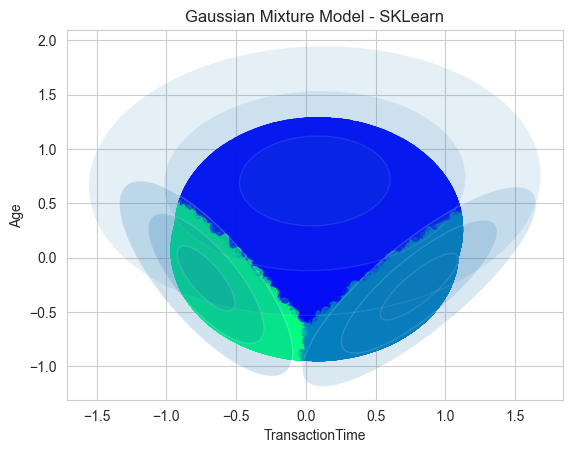

In [162]:
plt.scatter(X_principal['P1'], X_principal['P2'], c = clusters, cmap =plt.cm.winter, alpha = 0.6) 

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

w_factor = 0.2 / max(weights)

for pos, covar, w in zip(means, covariances, weights):
    w2 = w * w_factor

    # Convert covariance to principal axes
    if covar.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covar)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covar)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ellipse = Ellipse(pos, nsig * width, nsig * height, angle)
        ellipse.set_alpha(w2)
        plt.gca().add_patch(ellipse)

plt.xlabel('TransactionTime')
plt.ylabel('Age')
plt.title('Gaussian Mixture Model - SKLearn')
plt.show()

__________________
### Task 1.2: Implementacion de Mixture Models con libreria

Como primer paso, se utilizó la métrica de NLL (Negative Log-Likelihood) score (que viene integrada con el modelo de gaussian mixture) para determinar los mejores hiperparámetros para el modelo. En este caso, el hiperparámetro que se estaba tunneando era número de clusters. 

En este caso, como se puede observar a continuación, se determinó que el mejor número de clusters sería 3. 

k: 1 NLL: 1.8654786767344993
k: 2 NLL: 1.2201778247222006
k: 3 NLL: 0.7583239883069048
k: 4 NLL: 0.593957528965088
k: 5 NLL: 0.5207940901019928
k: 6 NLL: 0.4079944666052883
k: 7 NLL: 0.24566262328661462
k: 8 NLL: 0.1471411569056294


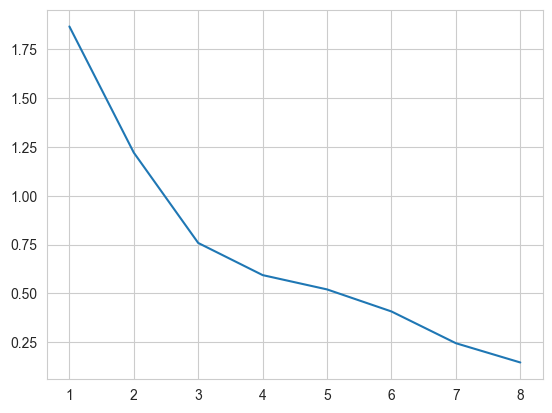

In [137]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import numpy as np

def calculate_NLL(X, kmax=10):
    nll = []
    for k in range(1, kmax+1):
        gmm = GaussianMixture(n_components = k) 
        gmm.fit(X)
        curr_nll = -gmm.score(X)
        print("k:", k, "NLL:", curr_nll)
        nll.append(curr_nll)
    return nll

nll = calculate_NLL(X_principal, kmax=8)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1, 9))
ax.plot(x_plot, nll)

En base al procedimiento anterior, se prosiguió con la creación del modelo Gaussiano Mixto. A este se le pasó como parámetro 3, para que se hagan 3 conjuntos de datos.

In [166]:
gmm = GaussianMixture(n_components = 3, n_init=10, tol=1e-6) 
gmm.fit(X_principal)

GaussianMixture(n_components=3, n_init=10, tol=1e-06)

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_60125/2825557119.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(pos, nsig * width, nsig * height, angle)


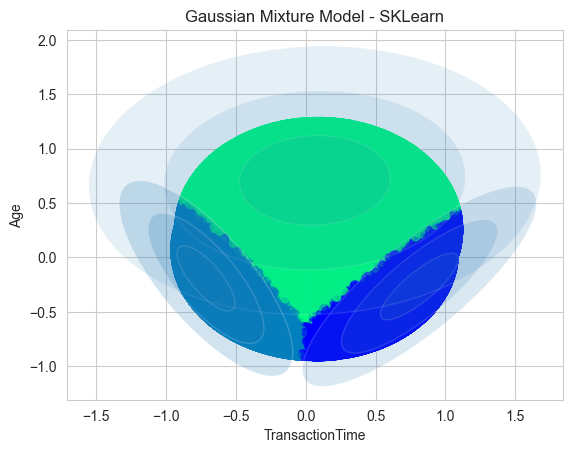

In [167]:
plt.scatter(X_principal['P1'], X_principal['P2'], c = GaussianMixture(n_components = 3, n_init=10, tol=1e-6).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

# means, covarianzas y pesos del gmm
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

w_factor = 0.2 / gmm.weights_.max()

for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    w2 = w * w_factor

    # Convert covariance to principal axes
    if covar.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covar)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covar)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ellipse = Ellipse(pos, nsig * width, nsig * height, angle)
        ellipse.set_alpha(w2)
        plt.gca().add_patch(ellipse)

plt.xlabel('TransactionTime')
plt.ylabel('Age')
plt.title('Gaussian Mixture Model - SKLearn')
plt.show()


En este caso, la métrica de Log Likelihood indica qué tan bien se crearon los clusters del respectivo modelo. Mientras más alto este valor, mejor.

In [168]:
log_likelihood = gmm.score(X_principal)
print("Log likelihood:", -log_likelihood)

Log likelihood: 1.0950033358709905
